In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators import solve_poisson_equation, psi_ln_sw, solve_poisson_equation_two_stream, fft_, density_convolve, linear_2_two_stream_SWSR

In [3]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib.pylab as pl
import matplotlib
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# Bump-on-Tail SW square-root

In [4]:
# set up configuration parameters
# number of mesh points in x
Nx = 30
# number of spectral expansions
Nv = 80
# velocity scaling of electron and ion
alpha_e1 = np.sqrt(2)
alpha_e2 = 1
alpha_i = np.sqrt(2 / 1863)
# perturbation magnitude
epsilon = 0.03
# x grid is from 0 to L
L = 20 * np.pi / 3
# final time
T = 20.
# velocity scaling
u_e1 = 0
u_e2 = 4.5
u_i = 0
# mass normalized
m_e1 = 1
m_e2 = 1
m_i = 1863
# charge normalized
q_e1 = -1
q_e2 = -1
q_i = 1
# scaling of bulk and bump
delta_e1 = 9/10
delta_e2 = 1/10

In [5]:
# velocity grid for plotting purposes
v = np.linspace(-5, 8, int(1e3))
# spatial grid 
x_project = np.linspace(0, L, int(1e5))
x = np.linspace(0, L, 2*Nx+1)

In [6]:
# initial condition of the first expansion coefficient
C_0i = np.zeros(2 * Nx + 1)
C_0i[Nx] = np.sqrt(1 / alpha_i)

In [7]:
# initial condition of the first expansion coefficient
C_0e1 = np.zeros(2 * Nx + 1, dtype="complex128")
C_0e2 = np.zeros(2 * Nx + 1, dtype="complex128")

# project the electron species onto fourier space
for ii, kk in enumerate(range(-Nx, Nx + 1)):
    C_0e1[ii] = np.trapz(y=np.sqrt(delta_e1 * (1 + epsilon * np.cos(0.3 * x_project)) / alpha_e1) * np.exp(-2 * np.pi * 1j * kk *  x_project / L),
                         x=x_project,
                         dx= x_project[1] -  x_project[0]) / L
    C_0e2[ii] = np.trapz(y=np.sqrt(delta_e2 * (1 + epsilon * np.cos(0.3 * x_project)) / alpha_e2) * np.exp(-2 * np.pi * 1j * kk *  x_project / L),
                         x= x_project,
                         dx= x_project[1] -  x_project[0]) / L

In [8]:
# initialize states (electrons and ions)
states_e1 = np.zeros((Nv, Nx * 2 + 1), dtype="complex128")
states_e2 = np.zeros((Nv, Nx * 2 + 1), dtype="complex128")
states_i = np.zeros((Nv, Nx * 2 + 1), dtype="complex128")

# initialize the expansion coefficients
states_e1[0, :] = C_0e1
states_e2[0, :] = C_0e2
states_i[0, :] = C_0i

In [9]:
E_coeff = solve_poisson_equation_two_stream(state_e1=states_e1,
                                            state_e2=states_e2,
                                            state_i=states_i,
                                            alpha_e1=alpha_e1,
                                            alpha_e2=alpha_e2,
                                            alpha_i=alpha_i,
                                            Nx=Nx, Nv=Nv,
                                            L=L, u_e1=u_e1, u_e2=u_e2, u_i=u_i)

In [10]:
# fft of electric field 
E_field= fft_(coeff=E_coeff, Nx=Nx, x=x, L=L)

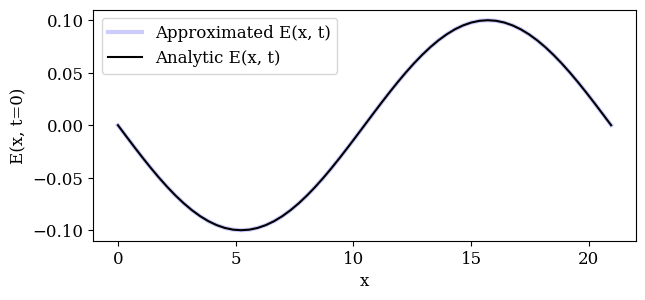

In [11]:
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(x, E_field, linewidth=3, color="blue", alpha=0.2, label="Approximated E(x, t)")
plt.plot(x, -0.1*np.sin(x * 0.3), color="black", label="Analytic E(x, t)")
plt.xlabel("x")
plt.ylabel("E(x, t=0)")
plt.legend()

In [12]:
# the distribution function of electrons and protons for plotting purposes
f_0e1 = np.outer(fft_(C_0e1, Nx, x, L), psi_ln_sw((v-u_e1)/alpha_e1, n=0)).real
f_0e2 = np.outer(fft_(C_0e2, Nx, x, L), psi_ln_sw((v-u_e2)/alpha_e2, n=0)).real
f_0i = np.outer(fft_(C_0i, Nx, x, L), psi_ln_sw((v-u_i)/alpha_i, n=0)).real

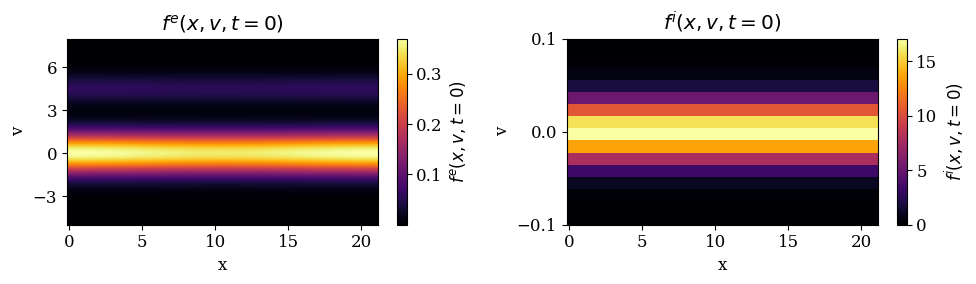

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, (f_0e1**2 + f_0e2**2).T, cmap="inferno")
ax[0].set_xlabel("x")
ax[0].set_ylabel("v")
ax[0].set_yticks([-3, 0, 3, 6])
cbar = fig.colorbar(pos)

cbar.ax.set_ylabel('$f^{e}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, (f_0i**2).T, cmap="inferno")
ax[1].set_ylim(-0.1, 0.1)
ax[1].set_yticks([-0.1, 0, 0.1])
ax[1].set_ylabel("v")
ax[1].set_xlabel("x")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{i}(x, v, t=0)$")
plt.tight_layout()
plt.savefig("figs/SW_sqrt/bump_on_tail/poisson/initial_condition_bump_on_tail.png", dpi=600)

In [14]:
def f_true(x, v):
    x_component = (1/np.sqrt(2*np.pi)) * (1 + 0.03*np.cos(0.3*x))
    v_component_1 = 9/10 * np.exp(-v**2/2)
    v_component_2 = 1/10 * np.exp(-(v-4.5)**2) * np.sqrt(2)
    return np.outer(x_component, (v_component_1 + v_component_2))

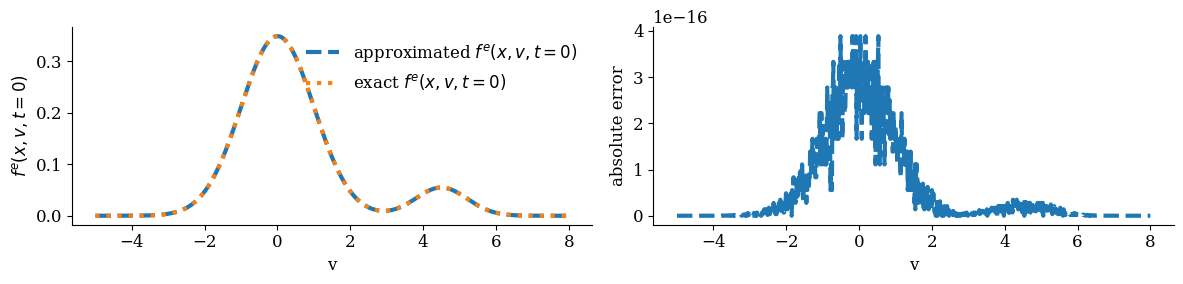

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 3))
ax[0].plot(v, f_0e1[Nx, :]**2 + f_0e2[Nx, :]**2, label="approximated $f^{e}(x, v, t=0)$", ls="--", linewidth=3)
ax[0].plot(v, f_true(x, v)[Nx, :], label="exact $f^{e}(x, v, t=0)$", ls=":", linewidth=3)
ax[0].set_xlabel("v")
ax[0].set_ylabel("$f^{e}(x, v, t=0)$")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
legend = ax[0].legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)


ax[1].plot(v, np.abs(f_0e1**2 + f_0e2**2 -f_true(x, v))[Nx, :], label="approximated $f^{e}(x, v, t=0)$", ls="--", linewidth=3)
ax[1].set_xlabel("v")
ax[1].set_ylabel("absolute error")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("figs/SW/bump_on_tail/poisson/sw_sqrt_initial_condition.png", dpi=600)

In [17]:
sol_midpoint_u = np.load("data/SW_sqrt/bump_on_tail/poisson/sol_midpoint_u_80.npy")
sol_midpoint_t = np.load("data/SW_sqrt/bump_on_tail/poisson/sol_midpoint_t_80.npy")
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(9760, 2001)
(2001,)


In [18]:
# initialize the electric potential
E_midpoint = np.zeros((2*Nx+1, len(sol_midpoint_t)), dtype="complex128")

In [19]:
# initialize the states for implicit midpoint (symplectic)
state_e1_midpoint = np.zeros((Nv, 2*Nx+1, len(sol_midpoint_t)), dtype="complex128")
state_e2_midpoint = np.zeros((Nv, 2*Nx+1, len(sol_midpoint_t)), dtype="complex128")
state_i_midpoint = np.zeros((Nv, 2*Nx+1, len(sol_midpoint_t)), dtype="complex128")


for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the linear system
        state_e1_midpoint[jj, :, ii] = sol_midpoint_u[jj * (2 * Nx + 1): (jj + 1) * (2 * Nx + 1), ii]
        state_e2_midpoint[jj, :, ii] = sol_midpoint_u[Nv*(2 * Nx + 1) + jj * (2 * Nx + 1): Nv*(2 * Nx + 1) + (jj + 1) * (2 * Nx + 1), ii]
        state_i_midpoint[0, Nx, ii] = np.sqrt(1 / alpha_i)
        
    E_midpoint[:, ii] = solve_poisson_equation_two_stream(state_e1=state_e1_midpoint[:, :, ii],
                                                          state_e2=state_e2_midpoint[:, :, ii],
                                                          state_i=state_i_midpoint[:, :, ii],
                                                          alpha_e1=alpha_e1,
                                                          alpha_e2=alpha_e2,
                                                          alpha_i=alpha_i,
                                                          Nx=Nx, Nv=Nv, solver="SWSR",
                                                          L=L, u_e1=u_e1, u_e2=u_e2, u_i=u_i)

In [76]:
E_field = np.zeros(np.shape(E_midpoint))
for ii in range(len(sol_midpoint_t)):
    E_field[:, ii] = fft_(E_midpoint[:, ii], Nx, x, L)

E_field_SW = np.load("E_field_SW.npy")

In [21]:
print(E_midpoint[Nx -1, 0])
print(E_midpoint[Nx + 1, 0])

(-2.042688844772316e-16-0.049999999999999656j)
(-2.042688844772316e-16+0.049999999999999656j)


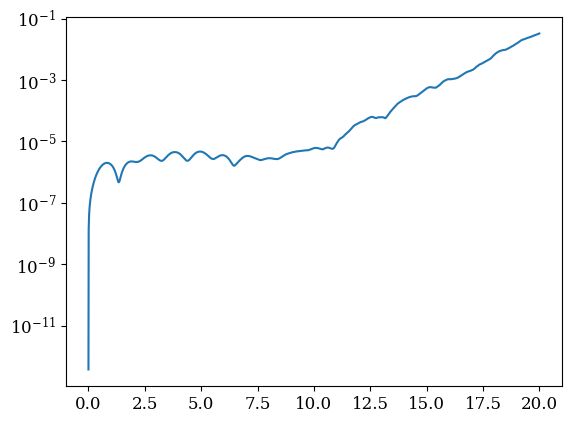

In [97]:
_ = plt.plot(sol_midpoint_t, np.sum(np.abs(E_field - E_field_SW), axis=0))
plt.yscale("log")

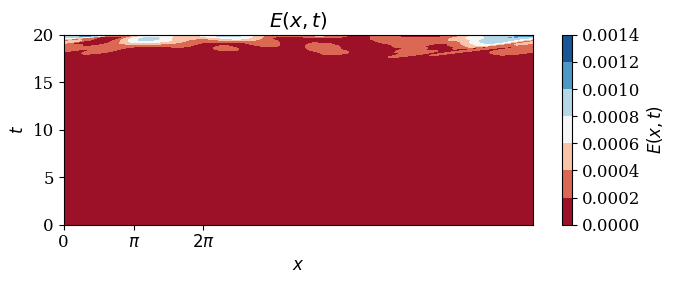

In [82]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x, sol_midpoint_t, np.abs(E_field - E_field_SW).T, cmap="RdBu")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("figs/SW_sqrt/bump_on_tail/poisson/electric_field_SW_sqrt.png", dpi=600)

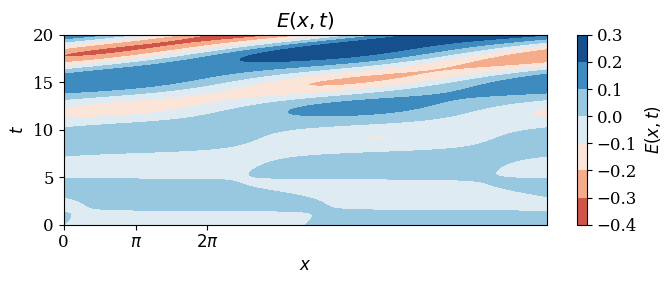

In [77]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x, sol_midpoint_t, E_field.T, cmap="RdBu", vmin=-0.5, vmax=0.3)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("figs/SW_sqrt/bump_on_tail/poisson/electric_field_SW_sqrt.png", dpi=600)

In [23]:
E1_midpoint = np.zeros(len(sol_midpoint_t))


for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(E_midpoint[Nx+1, ii])

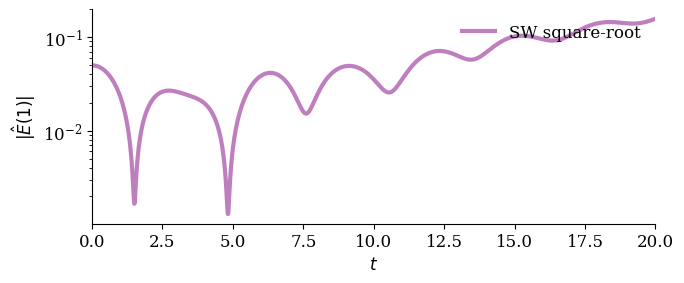

In [24]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "-", c="purple", alpha=0.5, linewidth=3, label="SW square-root") 
#ax.plot(sol_midpoint_t, np.exp(-0.851*sol_midpoint_t)*1e-2, linewidth=3, color="red", label=r"theory $\gamma = -0.851$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("figs/SW_sqrt/linear_landau/poisson/damping_rate_electric_field.png", dpi=600)

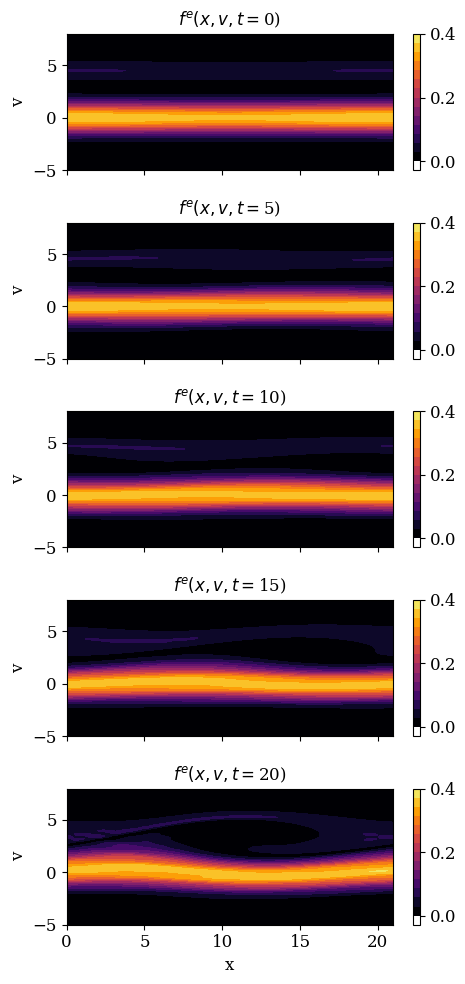

In [25]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(5, 10))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)//4))):
    distribution1 = np.zeros((2*Nx+1, len(v)))
    distribution2 = np.zeros((2*Nx+1, len(v)))
    for jj in range(Nv):
        distribution1 += np.outer(fft_(state_e1_midpoint[jj, :, ii], Nx, x, L), psi_ln_sw((v-u_e1)/alpha_e1, n=jj)).real
        distribution2 += np.outer(fft_(state_e2_midpoint[jj, :, ii], Nx, x, L), psi_ln_sw((v-u_e2)/alpha_e2, n=jj)).real
        
    levels = np.append(-0.1, np.linspace(0, 0.4, 15))
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
    pos = ax[tt].contourf(x, v, (distribution1**2 + distribution2**2).T, levels=levels, colors=np.append(["w"], colors))
    #ax[tt].set_xticks([0, 5*np.pi, 10*np.pi, 15*np.pi, 20*np.pi])
    #ax[tt].set_xticklabels([r"0", r"$5\pi$", r"$10\pi$", r"$15\pi$", r"$20\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_yticks([0, 0.2, 0.4])
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")", fontsize=12)
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("figs/SW_sqrt/bump_on_tail/poisson/bump_on_tail_evolution_SW_sqrt.png", dpi=600)

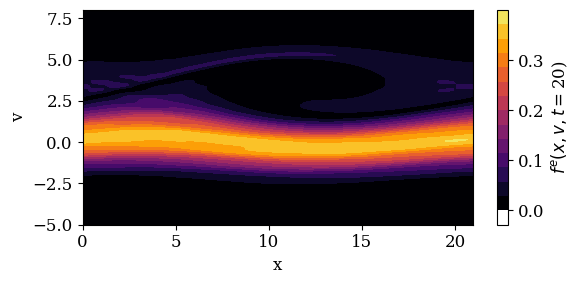

In [26]:
fig, ax = plt.subplots(figsize=(6, 3))

ii = -1

distribution1 = np.zeros((2*Nx+1, len(v)))
distribution2 = np.zeros((2*Nx+1, len(v)))

for jj in range(Nv):
    distribution1 +=  np.outer(fft_(state_e1_midpoint[jj, :, ii], Nx, x, L), psi_ln_sw((v-u_e1)/alpha_e1, n=jj)).real
    distribution2 +=  np.outer(fft_(state_e2_midpoint[jj, :, ii], Nx, x, L), psi_ln_sw((v-u_e2)/alpha_e2, n=jj)).real
    
levels = np.append(-0.1, np.linspace(0, 0.4, 15))
colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
pos = ax.contourf(x, v, (distribution1**2 + distribution2**2).T, levels=levels, colors=np.append(["w"], colors))
ax.set_xlabel("x")
ax.set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
plt.tight_layout()
plt.savefig("figs/SW_sqrt/bump_on_tail/poisson/bump_on_tail_electron_distribution_t_20_SW_sqrt.png", dpi=600)

In [27]:
rho = np.zeros((2*Nx+1, len(sol_midpoint_t)), dtype="complex128")
               
for ii in range(len(sol_midpoint_t)):
    rho[:, ii]  = linear_2_two_stream_SWSR(state_e1=state_e1_midpoint[:, :, ii], 
                                      state_e2=state_e2_midpoint[:, :, ii], 
                                      state_i=state_i_midpoint[:, :, ii], 
                                      alpha_e1=alpha_e1,
                                      alpha_e2=alpha_e2, 
                                      alpha_i=alpha_i)

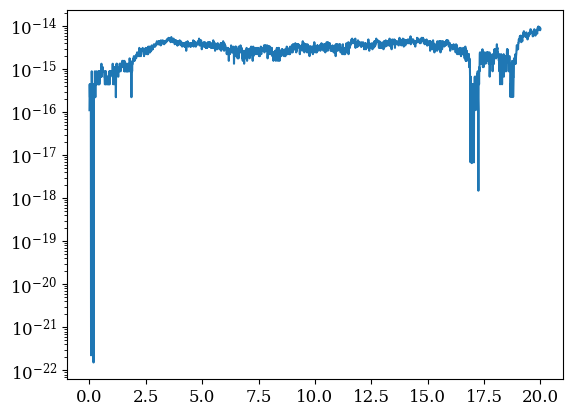

In [28]:
plt.plot(sol_midpoint_t, np.abs(rho[Nx, :]))
plt.yscale("log")

# Conservation Laws

### mass conservation 

$$
N^{s}(t) = \alpha^{s} \sum_{n=0}^{N_{v}-1} \int_{0}^{L} C_{n}^{s}(x, t)^{2}\mathrm{d}x =  \alpha^{s} \sum_{n=0}^{N_{v}-1} \int_{0}^{L} \sum_{k=-N_{x}}^{N_{x}} \sum_{m=-N_{x}}^{N_{x}} C_{n, k}^{s}(t) C_{n, m}^{s}(t) \exp(2\pi x i k/ L) \exp(2\pi x i m/ L) \mathrm{d}x
= \alpha^{s} L \sum_{n=0}^{N_{v}-1} \sum_{k=-N_{x}}^{N_{x}} C_{n, k}^{s}(t) C_{n, -k}^{s}(t)
$$


In [29]:
def mass(state):
    y = 0
    for nn in range(0, Nv):
        y += L * np.conjugate(state[nn, :]).T @ state[nn, :]
    return y 

In [30]:
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = mass(state_e1_midpoint[:, :, ii]).real*alpha_e1\
                      + mass(state_e2_midpoint[:, :, ii]).real*alpha_e2\
                      + mass(state_i_midpoint[:, :, ii]).real*alpha_i

In [31]:
mass_midpoint

array([41.88790205, 41.88790205, 41.88790205, ..., 41.88790205,
       41.88790205, 41.88790205])

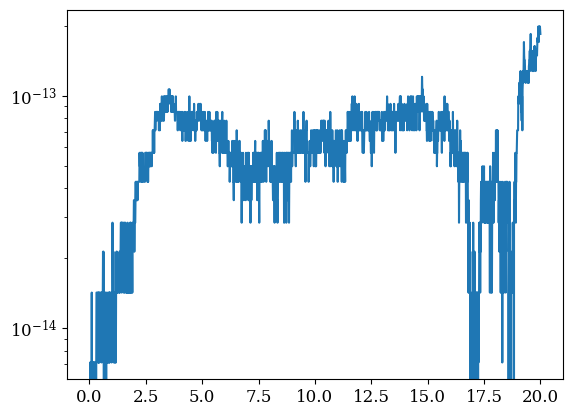

In [32]:
plt.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]))
plt.yscale("log")

### momentum conservation

In [37]:
def term2(state):
    res = 0
    for nn in range(0, Nv):
        res += L * np.sqrt(2) * np.sqrt(nn) * np.conjugate(state[nn-1, :]).T @ state[nn, :]
    return res

In [38]:
momentum_midpoint_e1 = np.zeros(len(sol_midpoint_t))
momentum_midpoint_e2 = np.zeros(len(sol_midpoint_t))
momentum_midpoint_i = np.zeros(len(sol_midpoint_t))
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint_e1[ii] = m_e1*alpha_e1*(alpha_e1*(term2(state_e1_midpoint[:, :, ii])) + u_e1*mass(state_e1_midpoint[:, :, ii])).real
    momentum_midpoint_e2[ii] = m_e2*alpha_e2*(alpha_e2*(term2(state_e2_midpoint[:, :, ii])) + u_e2*mass(state_e2_midpoint[:, :, ii])).real
    momentum_midpoint_i[ii] = 0
    momentum_midpoint[ii] = momentum_midpoint_e1[ii] + momentum_midpoint_e2[ii] + momentum_midpoint_i[ii]

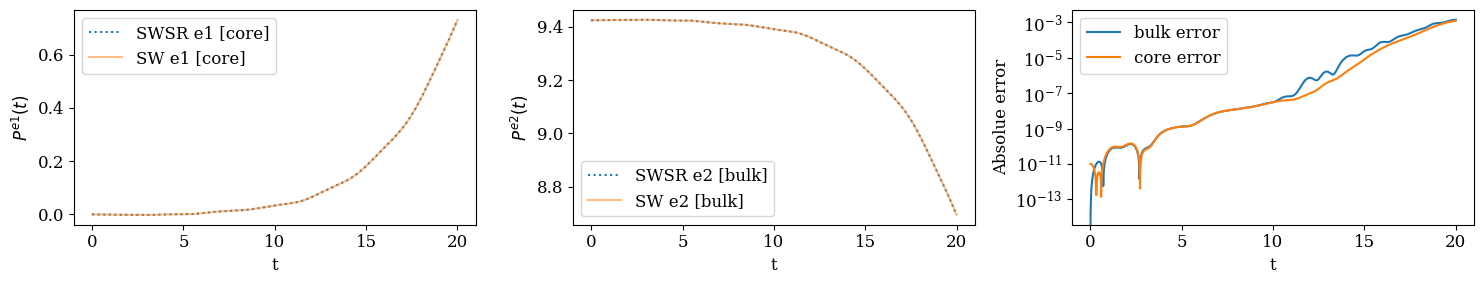

In [75]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
momentum_midpoint_e1_sw = np.load("momentum_e1_sw.npy")
momentum_midpoint_e2_sw = np.load("momentum_e2_sw.npy")

ax[0].plot(sol_midpoint_t, momentum_midpoint_e1, ls=":", label="SWSR e1 [core]")
ax[0].plot(sol_midpoint_t, momentum_midpoint_e1_sw, alpha=0.5, label="SW e1 [core]")

ax[1].plot(sol_midpoint_t, momentum_midpoint_e2, ls=":", label="SWSR e2 [bulk]")
ax[1].plot(sol_midpoint_t, momentum_midpoint_e2_sw, alpha=0.5, label="SW e2 [bulk]")

ax[2].plot(sol_midpoint_t,  np.abs(momentum_midpoint_e1 - momentum_midpoint_e1_sw), label="bulk error")
ax[2].plot(sol_midpoint_t,  np.abs(momentum_midpoint_e2 - momentum_midpoint_e2_sw), label="core error")
ax[2].set_ylabel("Absolue error")
ax[2].set_yscale("log")

ax[0].set_xlabel("t")
ax[1].set_xlabel("t")
ax[2].set_xlabel("t")
ax[0].set_ylabel("$P^{e1}(t)$")
ax[1].set_ylabel("$P^{e2}(t)$")

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
#plt.yscale("log")

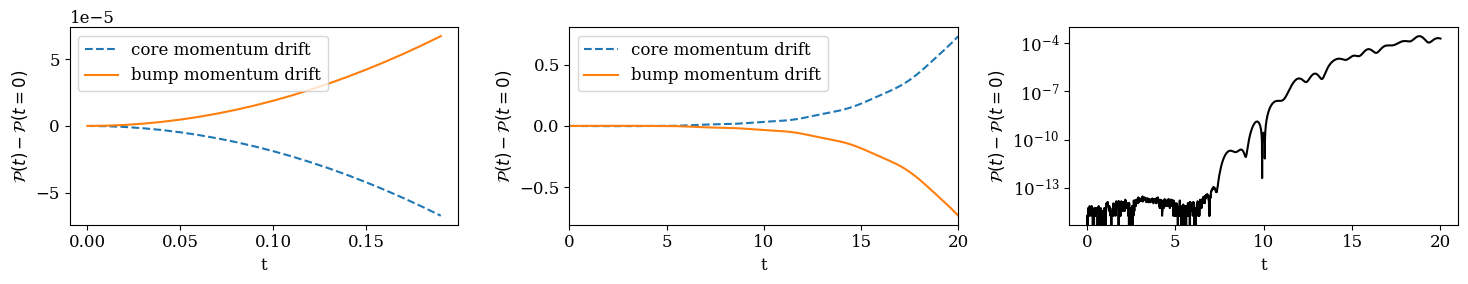

In [40]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
ax[1].plot(sol_midpoint_t, momentum_midpoint_e1-momentum_midpoint_e1[0], ls="--",  label="core momentum drift")
ax[1].plot(sol_midpoint_t, momentum_midpoint_e2-momentum_midpoint_e2[0], label="bump momentum drift")
ax[1].set_xlabel("t")
ax[1].set_xlim(0, T)
ax[1].legend()
ax[1].set_ylabel(r"$\mathcal{P}(t)-\mathcal{P}(t=0)$")

ax[0].plot(sol_midpoint_t[:20], momentum_midpoint_e1[:20]-momentum_midpoint_e1[0], ls="--",  label="core momentum drift")
ax[0].plot(sol_midpoint_t[:20], momentum_midpoint_e2[:20]-momentum_midpoint_e2[0], label="bump momentum drift")
ax[0].set_xlabel("t")
ax[0].legend()
ax[0].set_ylabel(r"$\mathcal{P}(t)-\mathcal{P}(t=0)$")

ax[2].plot(sol_midpoint_t, np.abs(momentum_midpoint_e1-momentum_midpoint_e1[0]+  momentum_midpoint_e2-momentum_midpoint_e2[0]), label="total momentum drift", c="black")
ax[2].set_yscale("log")
ax[2].set_xlabel("t")
ax[2].set_ylabel(r"$\mathcal{P}(t)-\mathcal{P}(t=0)$")
plt.tight_layout()

### Energy conservation

In [54]:
def term3(state, ii):
    Nv, Nx, Nt = np.shape(state)
    res = 0
    for m in range(0, Nv):
        res += L * (m + 0.5) * np.conjugate(state[m, :, ii]).T @ state[m, :, ii]
    return res

def term4(state, ii):
    Nv, Nx, Nt = np.shape(state)
    res = 0
    for m in range(2, Nv):
        res += L * np.sqrt((m)*(m-1)) * np.conjugate(state[m-2, :, ii]).T @ state[m, :, ii]
    return res

In [55]:
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = m_e1*alpha_e1*(0.5*((u_e1**2)*mass(state_e1_midpoint[:, :, ii]) + (alpha_e1**2)*term3(state_e1_midpoint, ii)) + 2*u_e1*alpha_e1*term2(state_e1_midpoint[:, :, ii]) + 0.5*(alpha_e1**2)*term4(state_e1_midpoint, ii)).real\
                           +m_e2*alpha_e2*(0.5*((u_e2**2)*mass(state_e2_midpoint[:, :, ii]) + (alpha_e2**2)*term3(state_e2_midpoint, ii)) + 2*u_e2*alpha_e2*term2(state_e2_midpoint[:, :, ii]) + 0.5*(alpha_e2**2)*term4(state_e2_midpoint, ii)).real\
                           +m_i*alpha_i*(0.5*((u_i**2)*mass(state_i_midpoint[:, :, ii]) + (alpha_i**2)*term3(state_i_midpoint, ii)) + 2*u_i*alpha_i*term2(state_i_midpoint[:, :, ii]) + 0.5*(alpha_i**2)*term4(state_i_midpoint, ii)).real
    
    energy_p_midpoint[ii] = 0.5 * L * (np.sum(np.conjugate(E_midpoint[:, ii]).T @ E_midpoint[:, ii] )).real

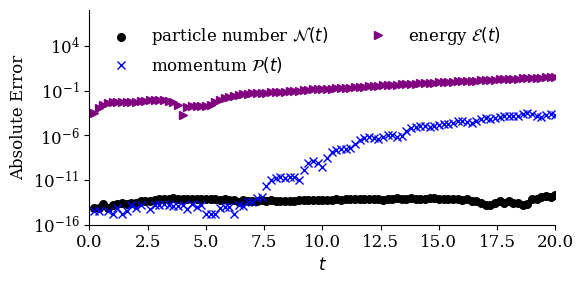

In [56]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 3))

ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]))[::20], ">",  color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_ylim(10**-16, 10**8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12, loc="upper left")
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("figs/Sw_sqrt/bump_on_tail/poisson/conservation_80_bump_on_tail_SW_sqrt.png", dpi=600)